In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

from deepmip_dict import deepmip_dict

data_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/aprp_output_data/'
cmip_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/data/cmip6/'
deepmip_dir = '/Volumes/WD_Elements/DeepMIP_database/ceda/deepmip-eocene-p1/'
figure_dir = '/Users/wb19586/Documents/coding_github/aprp_deepmip/figures/'


In [125]:
#### state dependence of global mean feedbacks

def select_area(da,min_lat,max_lat, lat_name='lat'):
    # Check if the latitude dimension is monotonically increasing or decreasing
    if da[lat_name].values[0] < da[lat_name].values[-1]:
        # Latitude is increasing
        return da.sel(lat=slice(min_lat, max_lat))
    else:
        # Latitude is decreasing
        return da.sel(lat=slice(max_lat, min_lat))

# calculate global mean feedback strengths first

# DeepMIP
gmsts = {}
feedbacks_gm = {}
feedbacks_NP = {}
feedbacks_SP = {}
feedbacks_T = {}

feedbacks_NP_land = {}
feedbacks_SP_land = {}
feedbacks_T_land = {}

feedbacks_NP_ocean = {}
feedbacks_SP_ocean = {}
feedbacks_T_ocean = {}

for model in deepmip_dict.keys():
    print(model)
    for i in range(deepmip_dict[model]['ncase'] - deepmip_dict[model]['nsens']):

        # if deepmip_dict[model]['contr'][i] == 'deepmip-eocene-p1-PI':
        #     continue
        print(deepmip_dict[model]['contr'][i])

        aprp_file = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.aprp.nc'
        aprp      = xr.open_dataset(data_dir + '/deepmip/' + aprp_file, decode_times=False)
        aprp = aprp.where(aprp <= 1e6, np.nan)
        aprp_ym   = aprp.mean('time')

        aprp_file_land = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.aprp.land.nc'
        aprp_land      = xr.open_dataset(data_dir + '/deepmip/' + aprp_file_land, decode_times=False)
        aprp_land = aprp_land.where(aprp_land <= 1e6, np.nan)
        aprp_ym_land   = aprp_land.mean('time')

        aprp_file_ocean = model + '.' + deepmip_dict[model]['contr'][i] +'.to.' + deepmip_dict[model]['sensi'][i] + '.aprp.ocean.nc'
        aprp_ocean      = xr.open_dataset(data_dir + '/deepmip/' + aprp_file_ocean, decode_times=False)
        aprp_ocean = aprp_ocean.where(aprp_ocean <= 1e6, np.nan)
        aprp_ym_ocean   = aprp_ocean.mean('time')
        
        # calculate area weights
        coslat     = np.cos(np.deg2rad(aprp.lat))
        
        gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
        gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
        dT        = (gmst2 - gmst1).values

        gmsts[f"{model}_{deepmip_dict[model]['contr'][i]}"] = gmst1

        var_list = ['alf','alf_clr','alf_oc','cld','cld_c','cld_ga','cld_mu','clr','clr_ga','clr_mu', 'tas1', 'tas2', 'cld_od']
        for var in var_list:

            # process global data
            if var == 'cld_od':
                aprp_ym_NP = select_area(aprp_ym["cld_ga"]+aprp_ym["cld_mu"],60,90)
                aprp_ym_SP = select_area(aprp_ym["cld_ga"]+aprp_ym["cld_mu"],-90,-60)
                aprp_ym_T = select_area(aprp_ym["cld_ga"]+aprp_ym["cld_mu"],-30,30)
            else:
                aprp_ym_NP = select_area(aprp_ym[var],60,90)
                aprp_ym_SP = select_area(aprp_ym[var],-90,-60)
                aprp_ym_T = select_area(aprp_ym[var],-30,30)

            coslat_NP = np.cos(np.deg2rad(aprp_ym_NP.lat))
            coslat_SP = np.cos(np.deg2rad(aprp_ym_SP.lat))
            coslat_T = np.cos(np.deg2rad(aprp_ym_T.lat))

            if ( var != 'tas1' and var != 'tas2' ):
                if var == 'cld_od':
                    data = aprp_ym["cld_ga"]+aprp_ym["cld_mu"]
                    feedback_gm = data.weighted(coslat).mean(('lat','lon')) / dT  
                else:
                    feedback_gm = aprp_ym[var].weighted(coslat).mean(('lat','lon')) / dT  
                feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon')) / dT
                feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon')) / dT
                feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon')) / dT
            else:
                feedback_gm = aprp_ym[var].weighted(coslat).mean(('lat','lon')) 
                feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon'))
                feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon'))
                feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon'))             

            feedbacks_gm[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_gm
            feedbacks_NP[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_NP
            feedbacks_SP[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_SP
            feedbacks_T[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_T
            
            # process land only data
            if var == 'cld_od':
                data = aprp_ym_land["cld_ga"]+aprp_ym_land["cld_mu"]
            else:
                data = aprp_ym_land[var]
            aprp_ym_NP_land = select_area(data,60,90)
            aprp_ym_SP_land = select_area(data,-90,-60)
            aprp_ym_T_land = select_area(data,-30,30)

            if ( var != 'tas1' and var != 'tas2' ):
                feedback_NP_land = aprp_ym_NP_land.weighted(coslat_NP).mean(('lat','lon')) / dT
                feedback_SP_land = aprp_ym_SP_land.weighted(coslat_SP).mean(('lat','lon')) / dT
                feedback_T_land = aprp_ym_T_land.weighted(coslat_T).mean(('lat','lon')) / dT
            else:
                feedback_NP_land = aprp_ym_NP_land.weighted(coslat_NP).mean(('lat','lon'))
                feedback_SP_land = aprp_ym_SP_land.weighted(coslat_SP).mean(('lat','lon'))
                feedback_T_land = aprp_ym_T_land.weighted(coslat_T).mean(('lat','lon'))

            feedbacks_NP_land[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_NP_land
            feedbacks_SP_land[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_SP_land
            feedbacks_T_land[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_T_land

            # process ocean only data
            if var == 'cld_od':
                data = aprp_ym_ocean["cld_ga"]+aprp_ym_ocean["cld_mu"]
            else:
                data = aprp_ym_ocean[var]
            aprp_ym_NP_ocean = select_area(data,60,90)
            aprp_ym_SP_ocean = select_area(data,-90,-60)
            aprp_ym_T_ocean = select_area(data,-30,30)

            if ( var != 'tas1' and var != 'tas2' ):
                feedback_NP_ocean = aprp_ym_NP_ocean.weighted(coslat_NP).mean(('lat','lon')) / dT
                feedback_SP_ocean = aprp_ym_SP_ocean.weighted(coslat_SP).mean(('lat','lon')) / dT
                feedback_T_ocean = aprp_ym_T_ocean.weighted(coslat_T).mean(('lat','lon')) / dT
            else:
                feedback_NP_ocean = aprp_ym_NP_ocean.weighted(coslat_NP).mean(('lat','lon'))
                feedback_SP_ocean = aprp_ym_SP_ocean.weighted(coslat_SP).mean(('lat','lon'))
                feedback_T_ocean = aprp_ym_T_ocean.weighted(coslat_T).mean(('lat','lon'))

            feedbacks_NP_ocean[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_NP_ocean
            feedbacks_SP_ocean[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_SP_ocean
            feedbacks_T_ocean[f"{model}_{var}_{deepmip_dict[model]['contr'][i]}"] = feedback_T_ocean
# CMIP
gmsts_cmip = []
feedbacks_gm_cmip = {}
feedbacks_NP_cmip = {}
feedbacks_SP_cmip = {}
feedbacks_T_cmip = {}

for model in os.listdir(cmip_dir + "piControl/"):

    if model == '.DS_Store' or model == 'IPSL-CM6A-LR' or model == 'CMCC-CM2-SR5' or model == 'FGOALS-g3':
        continue
    
    aprp_file = model + '.piControl.to.abrupt-4xCO2.aprp.nc'
    aprp      = xr.open_dataset(data_dir + '/cmip/' + aprp_file, decode_times=False)
    aprp = aprp.where(aprp <= 1e6, np.nan)
    aprp_ym   = aprp.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp.lat))
    
    gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT        = (gmst2 - gmst1).values

    gmsts_cmip.append(gmst1.values)

    var_list = ['alf','alf_clr','alf_oc','cld','cld_c','cld_ga','cld_mu','clr','clr_ga','clr_mu', 'tas1', 'tas2', 'cld_od']
    for var in var_list:
        if var == 'cld_od':
            data = aprp_ym["cld_ga"]+aprp_ym["cld_mu"]
        else:
            data = aprp_ym[var]
        aprp_ym_NP = select_area(data,60,90)
        aprp_ym_SP = select_area(data,-90,-60)
        aprp_ym_T = select_area(data,-30,30)

        coslat_NP = np.cos(np.deg2rad(aprp_ym_NP.lat))
        coslat_SP = np.cos(np.deg2rad(aprp_ym_SP.lat))
        coslat_T = np.cos(np.deg2rad(aprp_ym_T.lat))

        if ( var != 'tas1' and var != 'tas2' ):
            if var == 'cld_od':
                data = aprp_ym["cld_ga"]+aprp_ym["cld_mu"]
            else:
                data = aprp_ym[var]
            feedback_gm = data.weighted(coslat).mean(('lat','lon')) / dT
            feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon')) / dT
            feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon')) / dT
            feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon')) / dT
        else:
            feedback_gm = aprp_ym[var].weighted(coslat).mean(('lat','lon'))
            feedback_NP = aprp_ym_NP.weighted(coslat_NP).mean(('lat','lon'))
            feedback_SP = aprp_ym_SP.weighted(coslat_SP).mean(('lat','lon'))
            feedback_T = aprp_ym_T.weighted(coslat_T).mean(('lat','lon'))

        feedbacks_gm_cmip[f"{var}_cmip_{model}"] = feedback_gm
        feedbacks_NP_cmip[f"{var}_cmip_{model}"] = feedback_NP
        feedbacks_SP_cmip[f"{var}_cmip_{model}"] = feedback_SP
        feedbacks_T_cmip[f"{var}_cmip_{model}"] = feedback_T


CESM1.2-CAM5
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1
deepmip-eocene-p1-x3
deepmip-eocene-p1-x6
COSMOS-landveg-r2413
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1
deepmip-eocene-p1-x3
GFDL-CM2.1
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1
deepmip-eocene-p1-x2
deepmip-eocene-p1-x3
deepmip-eocene-p1-x4
HadCM3B-M2.1aN
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1
deepmip-eocene-p1-x2
IPSLCM5A2
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1.5
MIROC4m
deepmip-eocene-p1-PI
deepmip-eocene-p1-x1
deepmip-eocene-p1-x2
NorESM1-F
deepmip-eocene-p1-PI
deepmip-eocene-p1-x2


In [3]:
# define the plotting function
# to do:
# change strength to parameter
def plot_feedbacks_area_means(feedbacks_dict, feedbacks_dict_cmip, axs, fig, ymin, ymax, title):
    row    = 0
    column = 0   
    for var in var_list:
        if var == 'cld_mu':
            continue
        for model in deepmip_dict.keys():
            model_gmsts = []
            for key, data_array in gmsts.items():
                if key.startswith(model):
                    model_gmsts.append(data_array.item())
            model_feedbacks = []
            for key, data_array in feedbacks_dict.items():
                # combine cloud scattering and absorption
                if var == 'cld_ga':
                    if key.startswith(f"{model}_cld_ga_deepmip"):
                        cld_ga = data_array.item()
                    elif  key.startswith(f"{model}_cld_mu_deepmip"):
                        cld_mu = data_array.item()
                        model_feedbacks.append(cld_ga + cld_mu)                
                else:
                    if key.startswith(f"{model}_{var}_deepmip"):
                        model_feedbacks.append(data_array.item())                
            cmip_feedbacks = []
            for key, data_array in feedbacks_dict_cmip.items():
                # combine cloud scattering and absorption
                if var == 'cld_ga':
                    if key.startswith(f"cld_ga_cmip"):
                        cld_ga = data_array.item()
                    elif  key.startswith(f"cld_mu_cmip"):
                        cld_mu = data_array.item()
                        cmip_feedbacks.append(cld_ga + cld_mu)                
                else:
                    if key.startswith(f"{var}_cmip"):
                        cmip_feedbacks.append(data_array.item())   
                        
            axs[row,column].axhline(y=0.0, color='gray', linestyle='--',zorder=1)

            axs[row,column].boxplot(cmip_feedbacks, positions=[np.mean(gmsts_cmip)], widths=1.5)
            
            axs[row,column].plot(model_gmsts, model_feedbacks, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
            axs[row,column].set_title(var, fontsize=16)
            axs[row,column].set_xlabel('GMST [°C]', fontsize=10)
            axs[row,column].set_ylabel('feedback parameter [Wm$^{-2}$°C$^{-1}$]', fontsize=10)
            axs[row,column].set_ylim([ymin, ymax])
            axs[row,column].set_xlim([12.0, 32.5])
            axs[row,column].set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])

        
        if var == 'alf_oc':
            row = 1
            column = 0
        elif var == 'cld_ga':
            row = 2
            column = 0   
        else:
            column += 1
    # Adjustments to the figure
    axs[2,2].legend(prop={"size": 9})
    # axs[0, 3].axis('off')
    # axs[2, 3].axis('off')
    fig.suptitle(title, fontsize=24)
    fig.tight_layout()



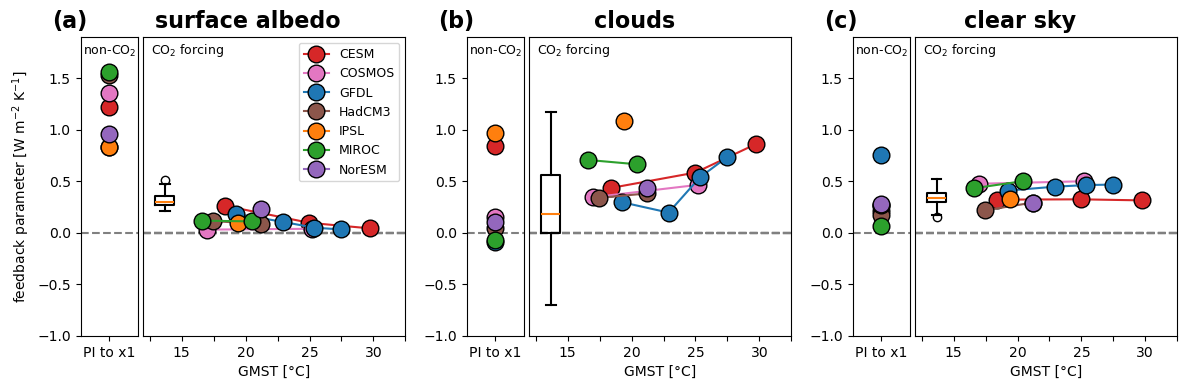

In [179]:
def plot_net_feedbacks(feedbacks_dict, feedbacks_dict_cmip, axs, fig, ymin, ymax, title):
    plot_num = 0
    titles = ['surface albedo', 'clouds', 'clear sky']
    panels = ['(a)', '(b)', '(c)']
    
    for var in ['alf', 'cld', 'clr']:
        for model_idx, model in enumerate(deepmip_dict.keys()):
            model_gmsts = []
            model_gmsts_non_co2 = []
            for key, data_array in gmsts.items():
                if key.startswith(f"{model}_deepmip-eocene-p1-PI"):
                    model_gmsts_non_co2.append(data_array.item())
                elif key.startswith(model):
                    model_gmsts.append(data_array.item())
                    
            model_feedbacks = []
            model_feedbacks_non_co2 = []
            for key, data_array in feedbacks_dict.items():
                if key.startswith(f"{model}_{var}_deepmip-eocene-p1-PI"):
                    model_feedbacks_non_co2.append(data_array.item())
                elif key.startswith(f"{model}_{var}_deepmip"):
                    model_feedbacks.append(data_array.item())
                    
            cmip_feedbacks = []
            for key, data_array in feedbacks_dict_cmip.items():
                if key.startswith(f"{var}_cmip"):
                    cmip_feedbacks.append(data_array.item())
                    
            axs[plot_num].axhline(y=0.0, color='gray', linestyle='--', zorder=1)
            axs[plot_num].plot(model_gmsts, model_feedbacks, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=100)
            # axs[plot_num].set_title(titles[plot_num], fontsize=14)
            axs[plot_num].set_xlabel('GMST [°C]', fontsize=10)

            # Remove y-axis labels from main plot
            axs[plot_num].tick_params(axis='y', labelleft=False, left=False)

            if plot_num == 0:
                axs[plot_num].tick_params(axis='y', labelleft=False, left=False) # Ensure it's off

            axs[plot_num].set_ylim([ymin, ymax])
            axs[plot_num].set_xlim([12.0, 32.5])
            axs[plot_num].set_xticks([12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5])
            axs[plot_num].set_xticklabels(["", "15", "", "20", "", "25", "", "30", ""])

            if model_idx == 0:
                axs[plot_num].boxplot(cmip_feedbacks, positions=[np.mean(gmsts_cmip)], widths=1.5, boxprops=dict(linewidth=1.5),whiskerprops=dict(linewidth=1.5),capprops=dict(linewidth=1.5),medianprops=dict(linewidth=1.5))
                ax2 = axs[plot_num].inset_axes([-0.24, 0, 0.22, 1], transform=axs[plot_num].transAxes)
                # ax2.scatter(np.ones(len(model_feedbacks)), model_feedbacks, marker="o", color=deepmip_dict[model]['pcolor'], edgecolor='k')

                ax2.set_xlim([0.5, 1.5])
                ax2.set_xticks([1])
                # ax2.set_xticklabels(['non-CO$_2$'])
                ax2.set_xticklabels(['PI to x1'])
                ax2.set_ylim([ymin, ymax])
                ax2.text(-0.35, 1.09, panels[plot_num], transform=axs[plot_num].transAxes, fontsize=16, fontweight='bold', va='top')
                axs[plot_num].text( 0.4, 1.09, titles[plot_num], transform=axs[plot_num].transAxes, fontsize=16, fontweight='bold', va='top', ha='center')
                ax2.axhline(y=0.0, color='gray', linestyle='--', zorder=1)
                ax2.text(0.51, 0.975, "non-CO$_2$", transform=ax2.transAxes, fontsize=9, fontweight='regular', va='top', ha='center')
                axs[plot_num].text(0.03, 0.982, "CO$_2$ forcing", transform=axs[plot_num].transAxes, fontsize=9, fontweight='regular', va='top', ha='left')

            ax2.plot(np.ones(len(model_gmsts_non_co2)), model_feedbacks_non_co2, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=100)
            ax2.tick_params(axis='y', labelleft=False)

            # Add y-axis label to categorical subplot
            if plot_num == 0:
                ax2.set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=10)
                ax2.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
            else:
                ax2.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

            
        plot_num += 1

    # Adjustments to the figure
    axs[0].legend(prop={"size": 9})
    fig.tight_layout()
    
    fig.savefig(figure_dir + '/net_feedback_scatter.pdf', bbox_inches='tight')

# Create publication figures
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_net_feedbacks(feedbacks_gm, feedbacks_gm_cmip, axs, fig, -1.0, 1.9, "")


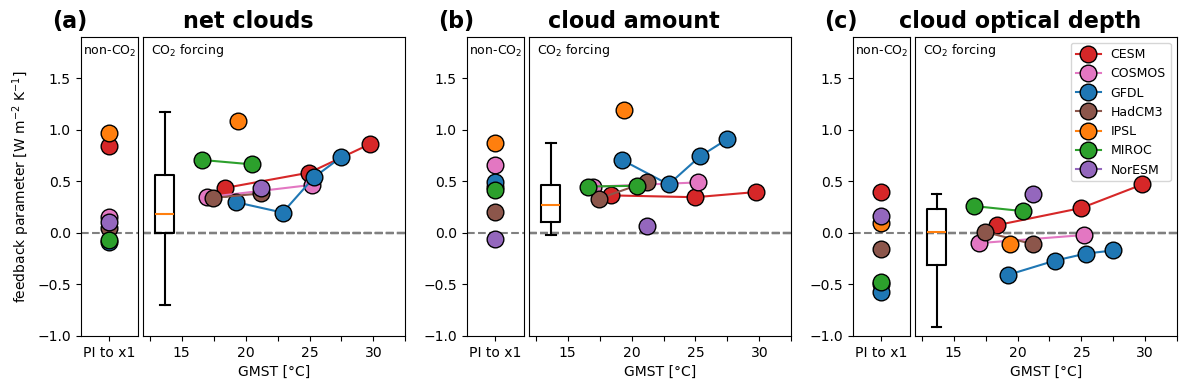

In [180]:
def plot_cloud_components(feedbacks_dict, feedbacks_dict_cmip, axs, fig, ymin, ymax, title):
    plot_num = 0
    titles = ['net clouds', 'cloud amount', 'cloud optical depth']
    panels = ['(a)', '(b)', '(c)']
    for var in ['cld','cld_c','cld_od']:
        for model_idx,model in enumerate(deepmip_dict.keys()):
            model_gmsts = []
            model_gmsts_non_co2 = []
            for key, data_array in gmsts.items():
                if key.startswith(f"{model}_deepmip-eocene-p1-PI"):
                    model_gmsts_non_co2.append(data_array.item())
                elif key.startswith(model):
                    model_gmsts.append(data_array.item())
                    
            model_feedbacks = []
            model_feedbacks_non_co2 = []
            for key, data_array in feedbacks_dict.items():
                if key.startswith(f"{model}_{var}_deepmip-eocene-p1-PI"):
                    model_feedbacks_non_co2.append(data_array.item())
                elif key.startswith(f"{model}_{var}_deepmip"):
                    model_feedbacks.append(data_array.item())               
            cmip_feedbacks = []
            for key, data_array in feedbacks_dict_cmip.items():
                if key.startswith(f"{var}_cmip"):
                    cmip_feedbacks.append(data_array.item())   
                        
            axs[plot_num].axhline(y=0.0, color='gray', linestyle='--',zorder=1)
            # axs[plot_num].boxplot(cmip_feedbacks, positions=[np.mean(gmsts_cmip)], widths=1.5)
            axs[plot_num].plot(model_gmsts, model_feedbacks, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
            # axs[plot_num].set_title(titles[plot_num], fontsize=14)
            axs[plot_num].set_xlabel('GMST [°C]', fontsize=10)
            if plot_num ==0:
                axs[plot_num].set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=10)
            axs[plot_num].set_ylim([ymin, ymax])
            axs[plot_num].set_xlim([12.0, 32.5])
            axs[plot_num].set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
            # axs[plot_num].text(0.02, 0.98, panels[plot_num], transform=axs[plot_num].transAxes, fontsize=16, fontweight='bold', va='top')
            axs[plot_num].tick_params(axis='y', labelleft=False, left=False)

            if model_idx == 0:
                axs[plot_num].boxplot(cmip_feedbacks, positions=[np.mean(gmsts_cmip)], widths=1.5, boxprops=dict(linewidth=1.5),whiskerprops=dict(linewidth=1.5),capprops=dict(linewidth=1.5),medianprops=dict(linewidth=1.5))
                ax2 = axs[plot_num].inset_axes([-0.24, 0, 0.22, 1], transform=axs[plot_num].transAxes)
                # ax2.scatter(np.ones(len(model_feedbacks)), model_feedbacks, marker="o", color=deepmip_dict[model]['pcolor'], edgecolor='k')

                ax2.set_xlim([0.5, 1.5])
                ax2.set_xticks([1])
                # ax2.set_xticklabels(['non-CO$_2$'])
                ax2.set_xticklabels(['PI to x1'])
                ax2.set_ylim([ymin, ymax])
                ax2.text(-0.35, 1.09, panels[plot_num], transform=axs[plot_num].transAxes, fontsize=16, fontweight='bold', va='top')
                axs[plot_num].text( 0.4, 1.09, titles[plot_num], transform=axs[plot_num].transAxes, fontsize=16, fontweight='bold', va='top', ha='center')
                ax2.axhline(y=0.0, color='gray', linestyle='--', zorder=1)
                ax2.text(0.51, 0.975, "non-CO$_2$", transform=ax2.transAxes, fontsize=9, fontweight='regular', va='top', ha='center')
                axs[plot_num].text(0.03, 0.982, "CO$_2$ forcing", transform=axs[plot_num].transAxes, fontsize=9, fontweight='regular', va='top', ha='left')

            ax2.plot(np.ones(len(model_gmsts_non_co2)), model_feedbacks_non_co2, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=100)

            # Add y-axis label to categorical subplot
            if plot_num == 0:
                ax2.set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=10)
                ax2.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
            else:
                ax2.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

        plot_num += 1
        
    # Adjustments to the figure
    axs[2].legend(prop={"size": 9}, loc="upper right")
    fig.tight_layout()

    fig.savefig(figure_dir + '/cloud_components.pdf', bbox_inches='tight')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_cloud_components(feedbacks_gm, feedbacks_gm_cmip, axs, fig, -1.0, 1.9, "")

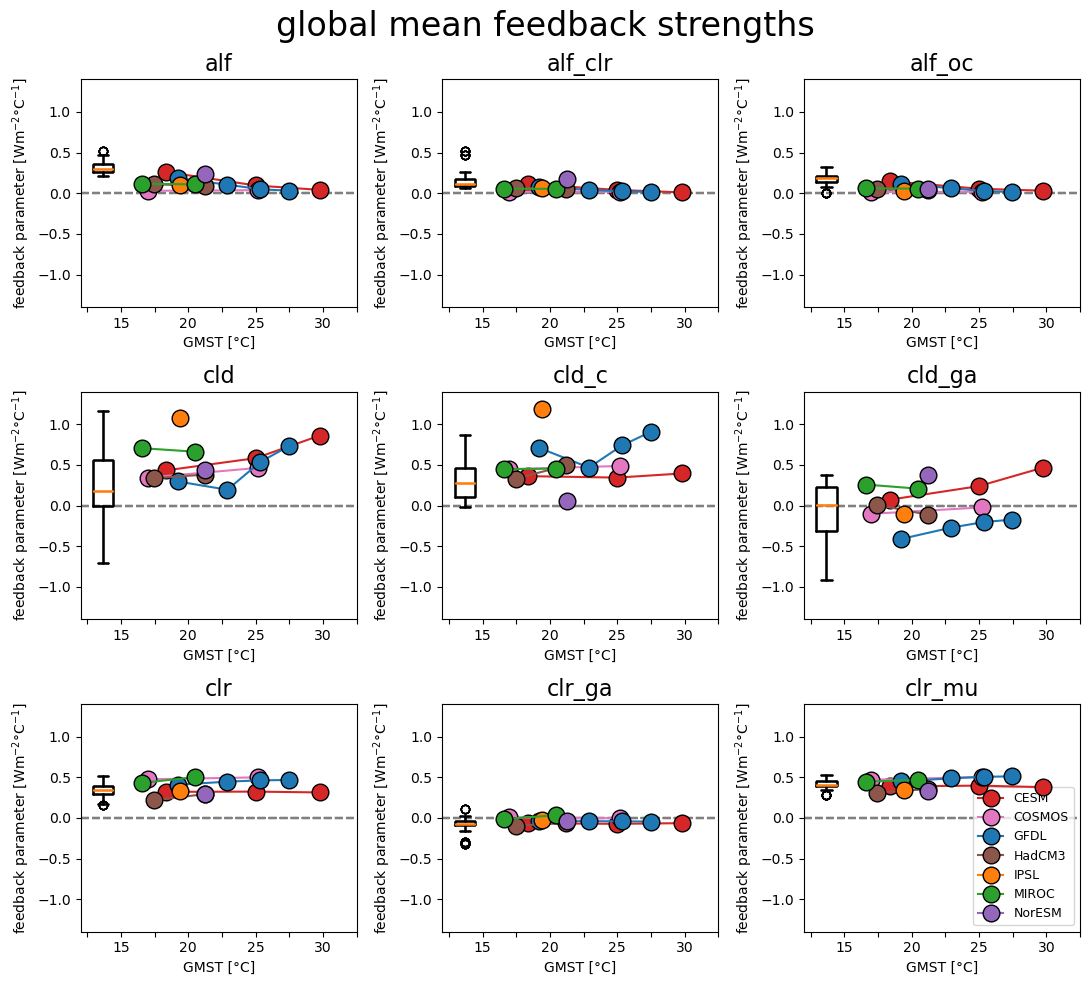

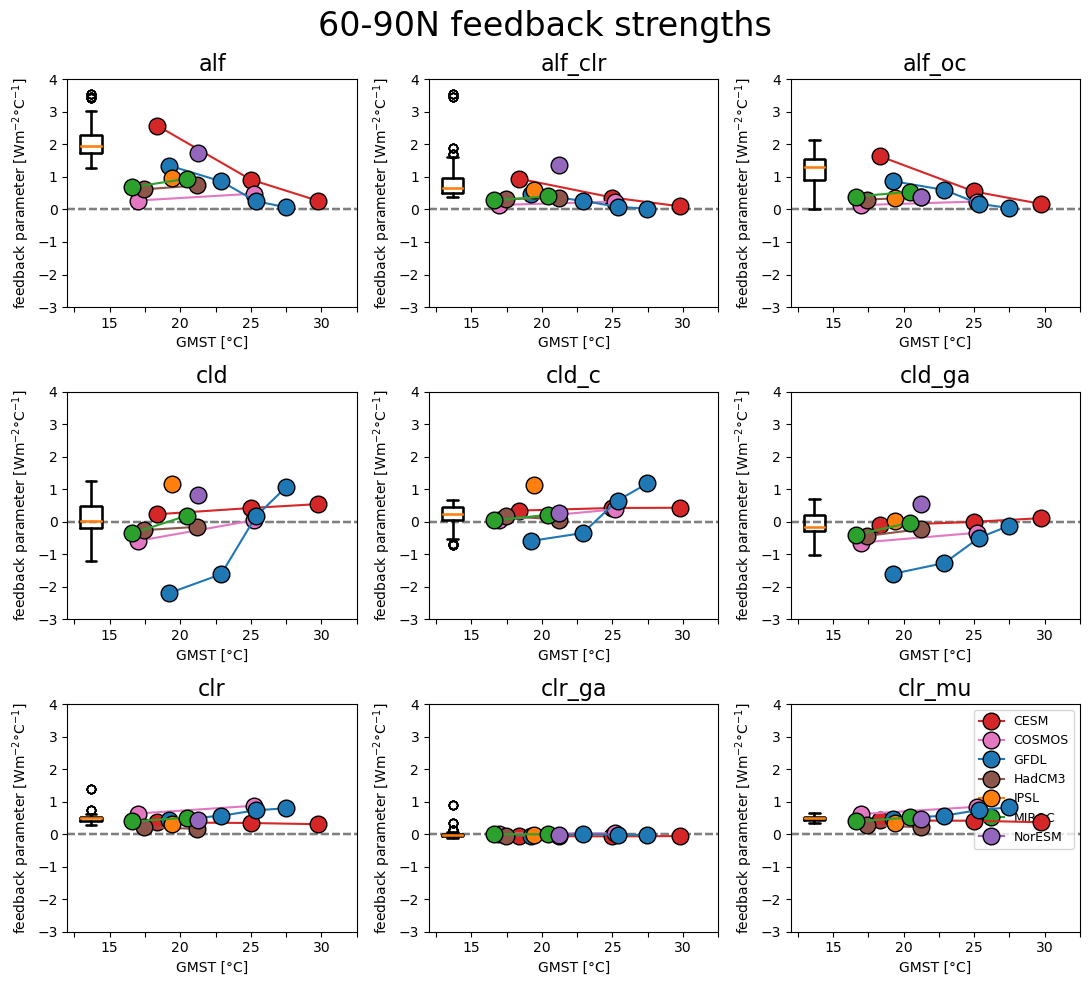

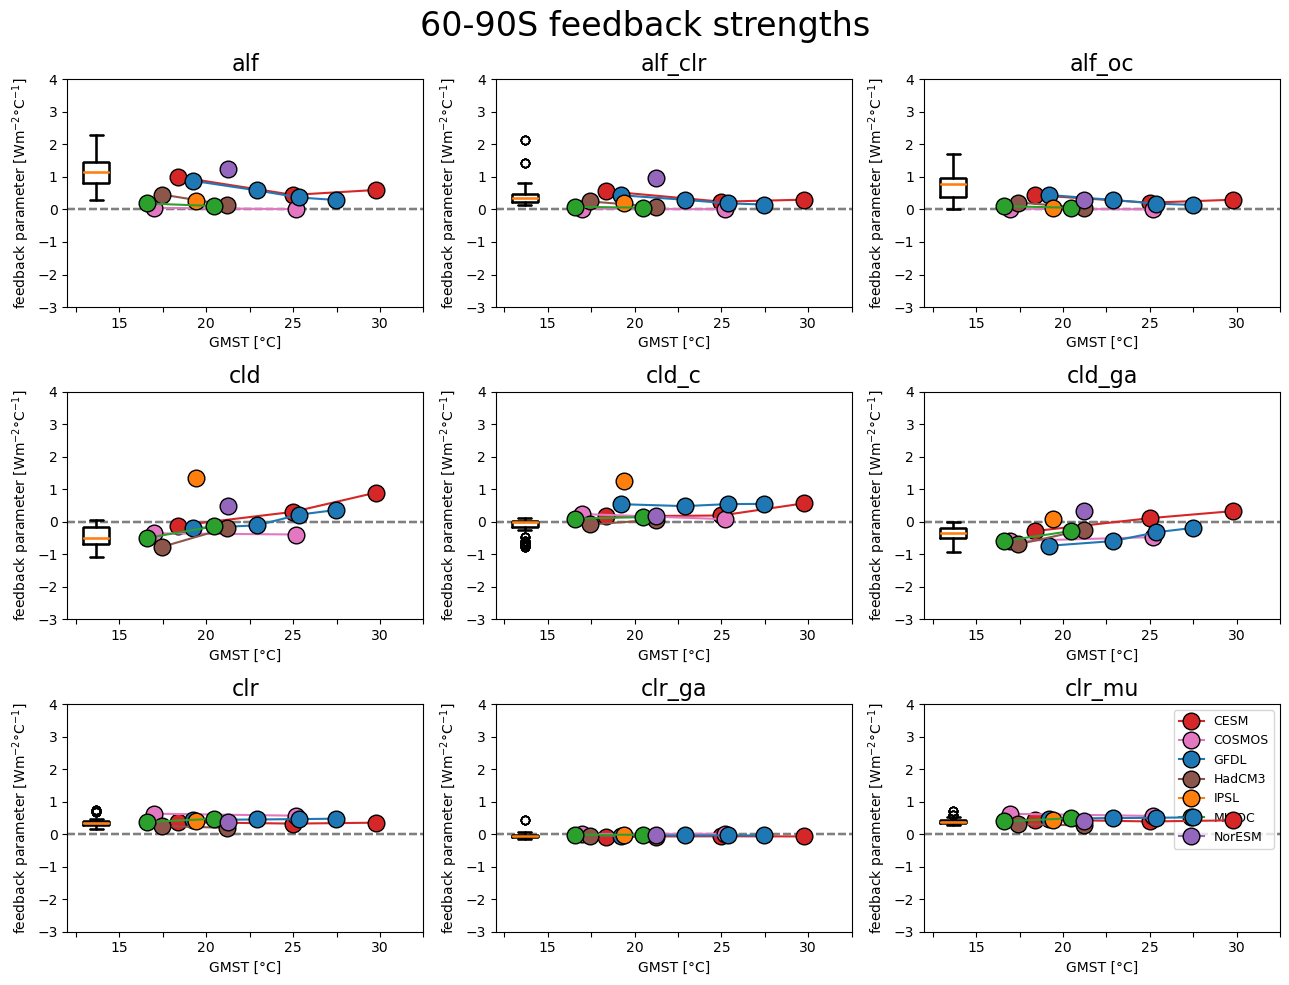

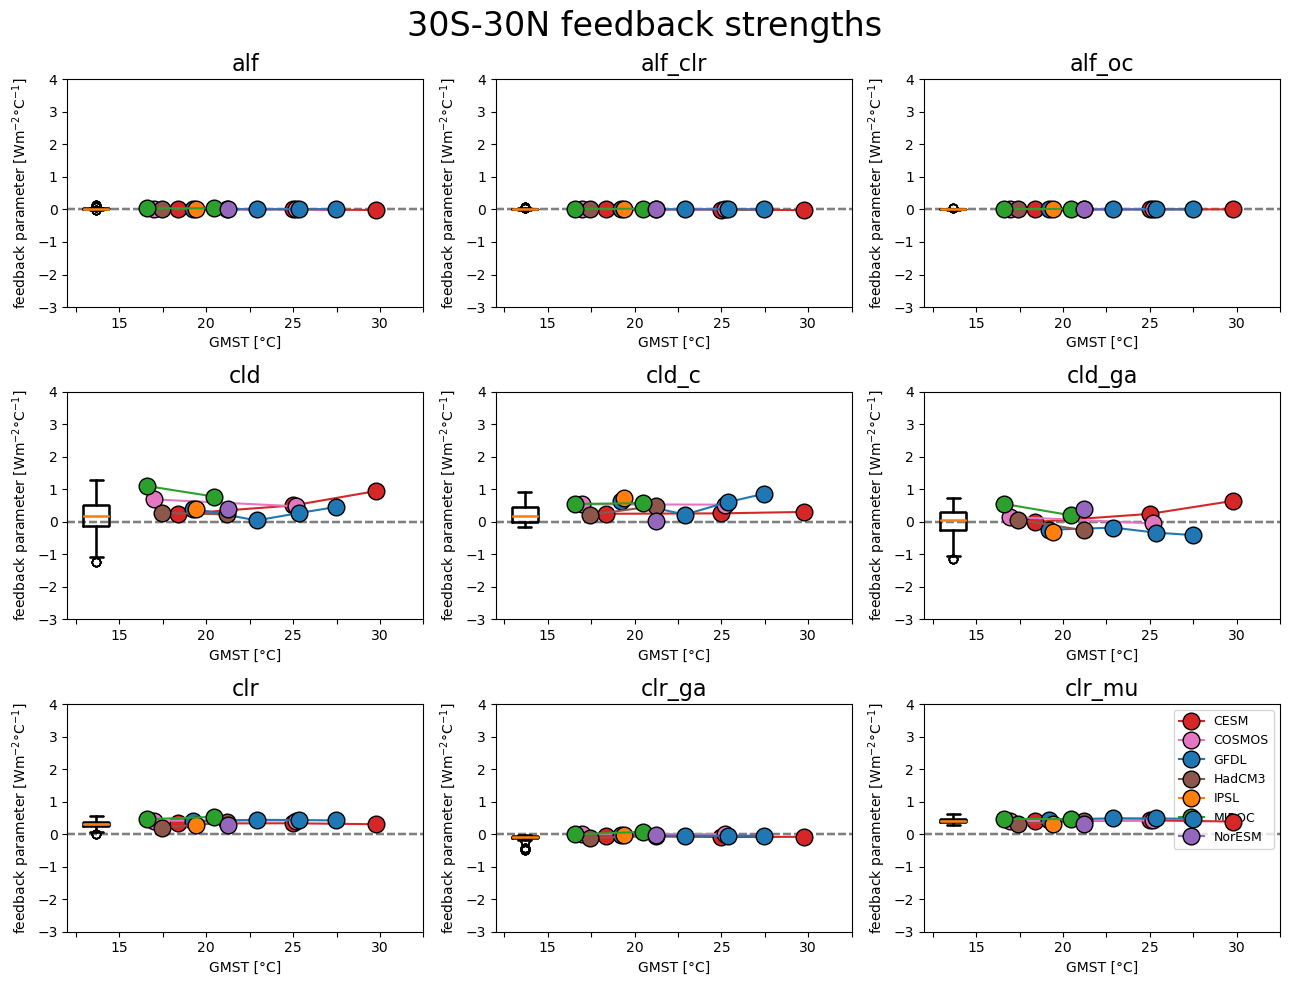

In [6]:
# Create overview figures
fig, axs = plt.subplots(3, 3, figsize=(11, 10))
plot_feedbacks_area_means(feedbacks_gm, feedbacks_gm_cmip, axs, fig, -1.4, 1.4, "global mean feedback strengths")

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
plot_feedbacks_area_means(feedbacks_NP, feedbacks_NP_cmip, axs, fig, -3.0, 4.0, "60-90N feedback strengths")

fig, axs = plt.subplots(3, 3, figsize=(13, 10))
plot_feedbacks_area_means(feedbacks_SP, feedbacks_SP_cmip, axs, fig, -3.0, 4.0, "60-90S feedback strengths")

fig, axs = plt.subplots(3, 3, figsize=(13, 10))
plot_feedbacks_area_means(feedbacks_T, feedbacks_T_cmip, axs, fig, -3.0, 4.0, "30S-30N feedback strengths")

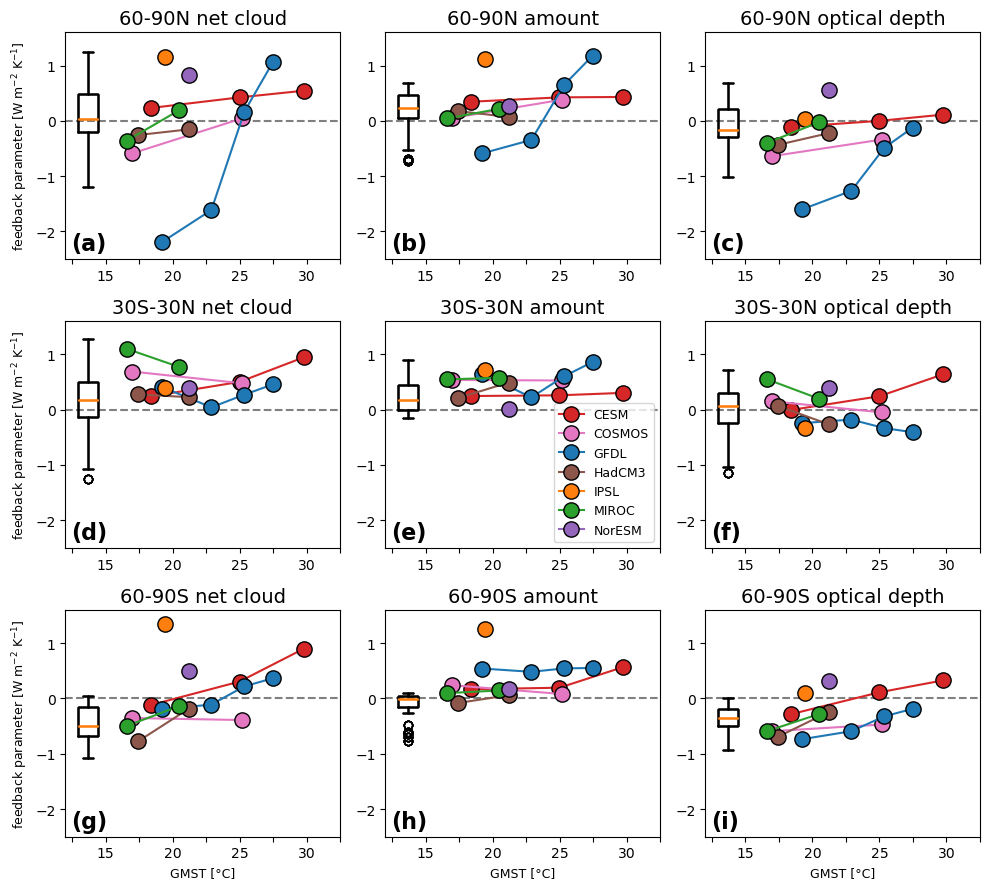

In [7]:
## focus on main cloud components

def retrieve_feedbacks(dict_deepmip, dict_cmip):
    model_feedbacks = []
    for key, data_array in dict_deepmip.items():
        if var == 'cld_ga':
            if key.startswith(f"{model}_cld_ga_deepmip"):
                cld_ga = data_array.item()
            elif key.startswith(f"{model}_cld_mu_deepmip"):
                cld_mu = data_array.item()
                model_feedbacks.append( cld_ga + cld_mu ) 
        else:
            if key.startswith(f"{model}_{var}_deepmip"):
                model_feedbacks.append(data_array.item())                
    cmip_feedbacks = []
    for key, data_array in dict_cmip.items():
        if var == 'cld_ga':
            if key.startswith(f"cld_ga_cmip_"):
                cld_ga = data_array.item()
            elif key.startswith(f"cld_mu_cmip_"):
                cld_mu = data_array.item()
                cmip_feedbacks.append( cld_ga + cld_mu )
        else:
            if key.startswith(f"{var}_cmip_"):
                cmip_feedbacks.append(data_array.item())  
    return model_feedbacks, cmip_feedbacks
        

fig, axs = plt.subplots(3, 3, figsize=(10, 9))

var_list = ['cld','cld_c','cld_ga']
titles = ['net cloud', 'amount', 'optical depth']

for var_idx,var in enumerate(var_list):
    for model in deepmip_dict.keys():
        model_gmsts = []
        for key, data_array in gmsts.items():
            if key.startswith(model):
                model_gmsts.append(data_array.item())
        model_feedbacks_gm, cmip_feedbacks_gm = retrieve_feedbacks(feedbacks_gm, feedbacks_gm_cmip)
        model_feedbacks_NP, cmip_feedbacks_NP = retrieve_feedbacks(feedbacks_NP, feedbacks_NP_cmip)
        model_feedbacks_SP, cmip_feedbacks_SP = retrieve_feedbacks(feedbacks_SP, feedbacks_SP_cmip)
        model_feedbacks_T, cmip_feedbacks_T = retrieve_feedbacks(feedbacks_T, feedbacks_T_cmip)

        # axs[0,var_idx].set_title('global ' + var, fontsize=16)
        # axs[0,var_idx].boxplot(cmip_feedbacks_gm, positions=[np.mean(gmsts_cmip)], widths=1.5)
        # axs[0,var_idx].plot(model_gmsts, model_feedbacks_gm, marker="o", markersize=12, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        axs[0,var_idx].set_title('60-90N ' + titles[var_idx], fontsize=14)
        axs[0,var_idx].boxplot(cmip_feedbacks_NP, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[0,var_idx].plot(model_gmsts, model_feedbacks_NP, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
        

        axs[1,var_idx].set_title('30S-30N ' + titles[var_idx], fontsize=14)
        axs[1,var_idx].boxplot(cmip_feedbacks_T, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[1,var_idx].plot(model_gmsts, model_feedbacks_T, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        axs[2,var_idx].set_title('60-90S ' + titles[var_idx], fontsize=14)
        axs[2,var_idx].boxplot(cmip_feedbacks_SP, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[2,var_idx].plot(model_gmsts, model_feedbacks_SP, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)
     


# fig.suptitle(title, fontsize=24)
panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
plot_num = 0
for ax in axs.flat:
    ax.axhline(y=0.0, color='gray', linestyle='--',zorder=1)
    ax.set_ylim([-2.5, 1.6])
    ax.set_xlim([12.0, 32.5])
    ax.set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
    ax.text(0.02, 0.12, panels[plot_num], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    plot_num += 1
    
axs[0,0].set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=9)
axs[1,0].set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=9)
axs[2,0].set_ylabel('feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=9)

axs[2,0].set_xlabel('GMST [°C]', fontsize=9)
axs[2,1].set_xlabel('GMST [°C]', fontsize=9)
axs[2,2].set_xlabel('GMST [°C]', fontsize=9)

axs[1,1].legend( loc = 'lower right', prop={"size": 9})

fig.tight_layout()

fig.savefig(figure_dir + '/regional_cloud_feedbacks.pdf', bbox_inches='tight')




- global mean cloud feedbacks in DeepMIP models always > 0 and at upper end of CMIP6 range
- tendency of increase with GMST
- strongest feedback in IPSL due to reduction in (mainly high-latitdue) clouds, which is much stronger than in CMIP6
- strongest nonlinearity in GFDL Arctic; extreme negative feedback switches sign at around 25 °C (both due to change in number of clouds and composition)
- overall nonlinear tendency seems to be related to scaterring/composition changes (not amount), particular over ice-free Antarctica!
- consistency in increaseing feddback strength over high latitudes, but inconsistencies in low latitudes, especially in scattering term

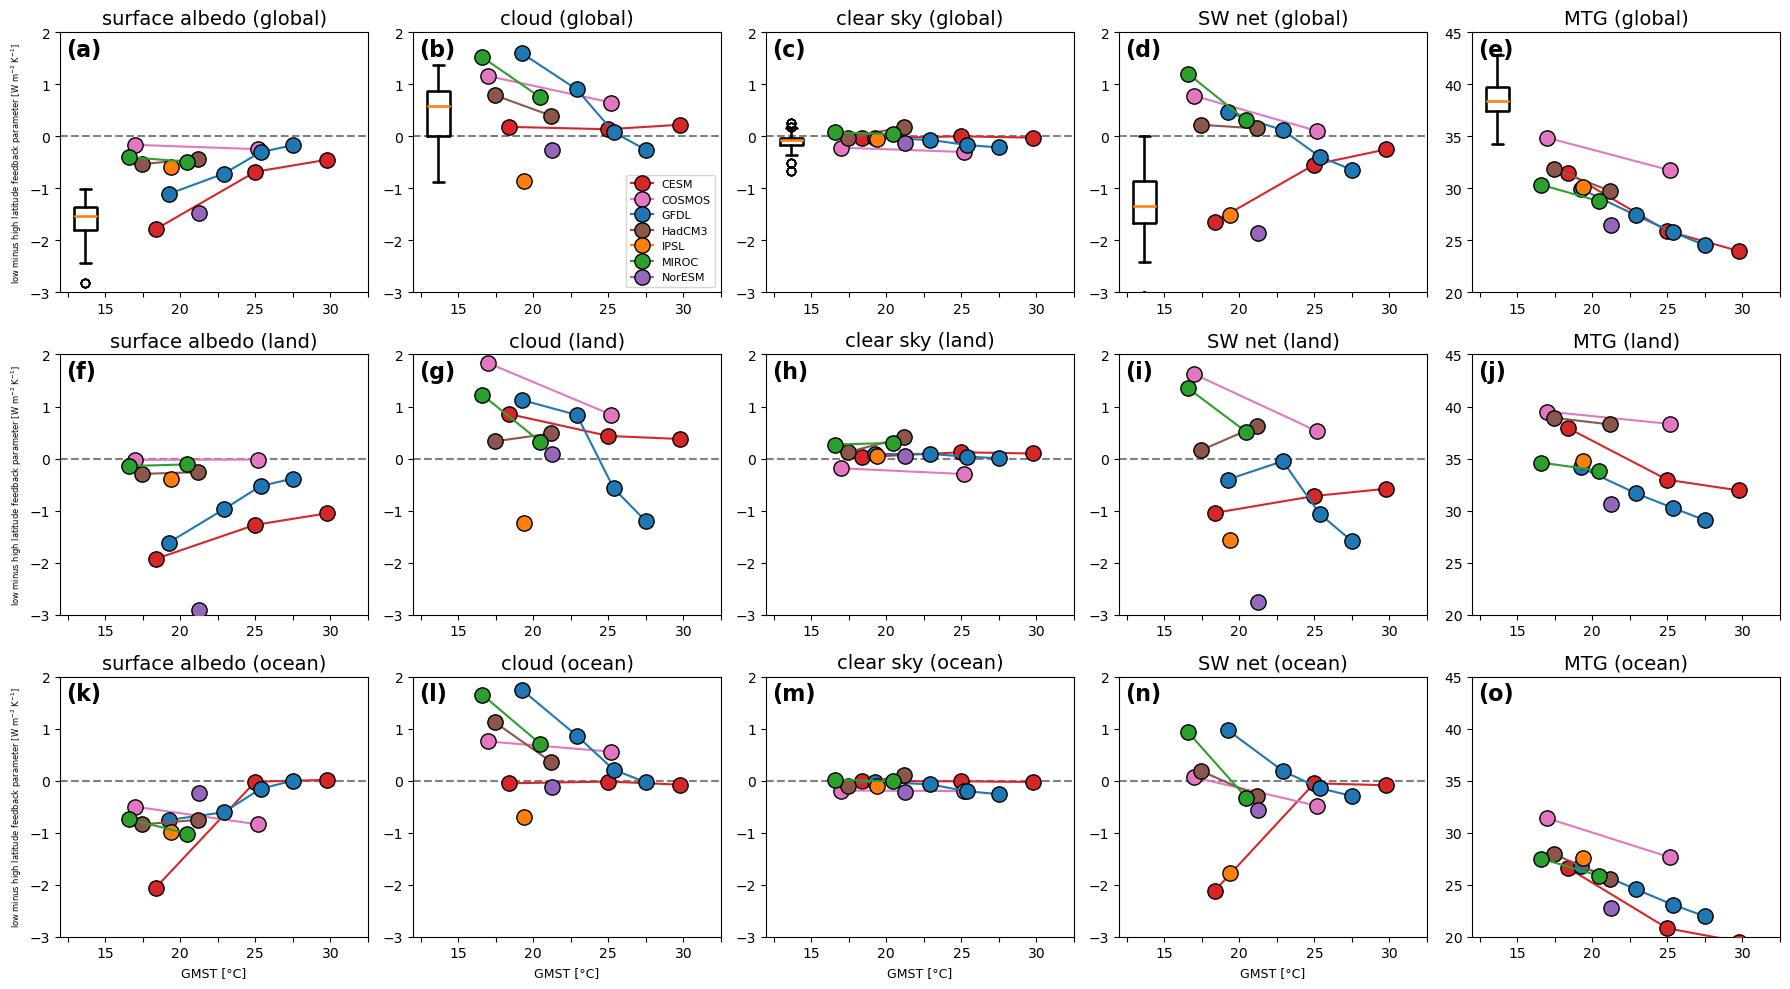

In [29]:
## feedback influence on MTG

def retrieve_feedbacks(dict_deepmip, dict_cmip):
    model_feedbacks = []
    for key, data_array in dict_deepmip.items():
        if var == 'net':
            if key.startswith(f"{model}_alf_deepmip"):
                alf = data_array.item()
            elif key.startswith(f"{model}_cld_deepmip"):
                cld = data_array.item()
            elif key.startswith(f"{model}_clr_deepmip"):
                clr = data_array.item()
                model_feedbacks.append( alf + cld + clr ) 
        else:
            if key.startswith(f"{model}_{var}_deepmip"):
                model_feedbacks.append(data_array.item())                
    cmip_feedbacks = []
    for key, data_array in dict_cmip.items():
        if var == 'net':
            if key.startswith(f"alf_cmip_"):
                alf = data_array.item()
            elif key.startswith(f"cld_cmip_"):
                cld = data_array.item()
            elif key.startswith(f"clr_cmip_"):
                clr = data_array.item()
                cmip_feedbacks.append( alf + cld + clr )
        else:
            if key.startswith(f"{var}_cmip_"):
                cmip_feedbacks.append(data_array.item())  
    return model_feedbacks, cmip_feedbacks
        

fig, axs = plt.subplots(3, 5, figsize=(18, 10))

var_list = ['alf', 'cld', 'clr','net', 'tas1']
# titles = ['surface albedo', 'cloud', 'albedo+cloud', 'MTG']
titles = ['surface albedo', 'cloud', 'clear sky', 'SW net', 'MTG']

for var_idx,var in enumerate(var_list):
    for model in deepmip_dict.keys():
        model_gmsts = []
        for key, data_array in gmsts.items():
            if key.startswith(model):
                model_gmsts.append(data_array.item())

        # global
        model_feedbacks_gm, cmip_feedbacks_gm = retrieve_feedbacks(feedbacks_gm, feedbacks_gm_cmip)
        model_feedbacks_NP, cmip_feedbacks_NP = retrieve_feedbacks(feedbacks_NP, feedbacks_NP_cmip)
        model_feedbacks_SP, cmip_feedbacks_SP = retrieve_feedbacks(feedbacks_SP, feedbacks_SP_cmip)
        model_feedbacks_T, cmip_feedbacks_T = retrieve_feedbacks(feedbacks_T, feedbacks_T_cmip)

        # Calculate the average high-latitude feedback
        polar_mean = [(np + sp) / 2 for np, sp in zip(model_feedbacks_NP, model_feedbacks_SP)]
        polar_amplification = [t - avg for t, avg in zip(model_feedbacks_T, polar_mean)]

        polar_mean_cmip = [(np + sp) / 2 for np, sp in zip(cmip_feedbacks_NP, cmip_feedbacks_SP)]
        polar_amplification_cmip = [t - avg for t, avg in zip(cmip_feedbacks_T, polar_mean_cmip)]
        
        axs[0,var_idx].set_title(titles[var_idx] + ' (global)', fontsize=14)
        axs[0,var_idx].boxplot(polar_amplification_cmip, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[0,var_idx].plot(model_gmsts, polar_amplification, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        # land
        model_feedbacks_NP_land, cmip_feedbacks_NP = retrieve_feedbacks(feedbacks_NP_land, feedbacks_NP_cmip)
        model_feedbacks_SP_land, cmip_feedbacks_SP = retrieve_feedbacks(feedbacks_SP_land, feedbacks_SP_cmip)
        model_feedbacks_T_land, cmip_feedbacks_T = retrieve_feedbacks(feedbacks_T_land, feedbacks_T_cmip)

        # Calculate the average high-latitude feedback
        polar_mean_land = [(np + sp) / 2 for np, sp in zip(model_feedbacks_NP_land, model_feedbacks_SP_land)]
        polar_amplification_land = [t - avg for t, avg in zip(model_feedbacks_T_land, polar_mean_land)]

        polar_mean_cmip = [(np + sp) / 2 for np, sp in zip(cmip_feedbacks_NP, cmip_feedbacks_SP)]
        polar_amplification_cmip = [t - avg for t, avg in zip(cmip_feedbacks_T, polar_mean_cmip)]
        
        axs[1,var_idx].set_title(titles[var_idx] + ' (land)', fontsize=14)
        # axs[1,var_idx].boxplot(polar_amplification_cmip, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[1,var_idx].plot(model_gmsts, polar_amplification_land, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        # ocean
        model_feedbacks_NP_ocean, cmip_feedbacks_NP = retrieve_feedbacks(feedbacks_NP_ocean, feedbacks_NP_cmip)
        model_feedbacks_SP_ocean, cmip_feedbacks_SP = retrieve_feedbacks(feedbacks_SP_ocean, feedbacks_SP_cmip)
        model_feedbacks_T_ocean, cmip_feedbacks_T = retrieve_feedbacks(feedbacks_T_ocean, feedbacks_T_cmip)

        # Calculate the average high-latitude feedback
        polar_mean_ocean = [(np + sp) / 2 for np, sp in zip(model_feedbacks_NP_ocean, model_feedbacks_SP_ocean)]
        polar_amplification_ocean = [t - avg for t, avg in zip(model_feedbacks_T_ocean, polar_mean_ocean)]

        polar_mean_cmip = [(np + sp) / 2 for np, sp in zip(cmip_feedbacks_NP, cmip_feedbacks_SP)]
        polar_amplification_cmip = [t - avg for t, avg in zip(cmip_feedbacks_T, polar_mean_cmip)]
        
        axs[2,var_idx].set_title(titles[var_idx] + ' (ocean)', fontsize=14)
        # axs[1,var_idx].boxplot(polar_amplification_cmip, positions=[np.mean(gmsts_cmip)], widths=1.5)
        axs[2,var_idx].plot(model_gmsts, polar_amplification_ocean, marker="o", markersize=11, markeredgecolor='k', color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'],zorder=100)

        # axs[0,3].set_title('MTG' + ' (global)', fontsize=14)
        # axs[1,3].set_title('MTG' + ' (land)', fontsize=14)
        # axs[2,3].set_title('MTG' + ' (ocean)', fontsize=14)



# fig.suptitle(title, fontsize=24)
panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)', '(n)', '(o)']
plot_num = 0
for idx,ax in enumerate(axs.flat):
    ax.axhline(y=0.0, color='gray', linestyle='--',zorder=1)
    if idx in [4,9,14]:
        ax.set_ylim([15, 45])
    else:
        ax.set_ylim([-3.0, 2.0])
    ax.set_xlim([12.0, 32.5])
    ax.set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
    ax.text(0.02, 0.98, panels[plot_num], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    plot_num += 1
    
axs[0,0].set_ylabel('low minus high latitude feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=6)
axs[1,0].set_ylabel('low minus high latitude feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=6)
axs[2,0].set_ylabel('low minus high latitude feedback parameter [W m$^{-2}$ K$^{-1}$]', fontsize=6)

axs[2,0].set_xlabel('GMST [°C]', fontsize=9)
axs[2,1].set_xlabel('GMST [°C]', fontsize=9)
axs[2,2].set_xlabel('GMST [°C]', fontsize=9)
axs[2,3].set_xlabel('GMST [°C]', fontsize=9)

axs[0,1].legend( loc = 'lower right', prop={"size": 8})

fig.tight_layout()

fig.savefig(figure_dir + '/mtg_feedbacks.pdf', bbox_inches='tight')




CESM1.2-CAM5
5.1287841796875
COSMOS-landveg-r2413
3.09320068359375
GFDL-CM2.1
3.603424072265625
HadCM3B-M2.1aN
3.50665283203125
IPSLCM5A2
6.225433349609375
MIROC4m
3.70367431640625
NorESM1-F


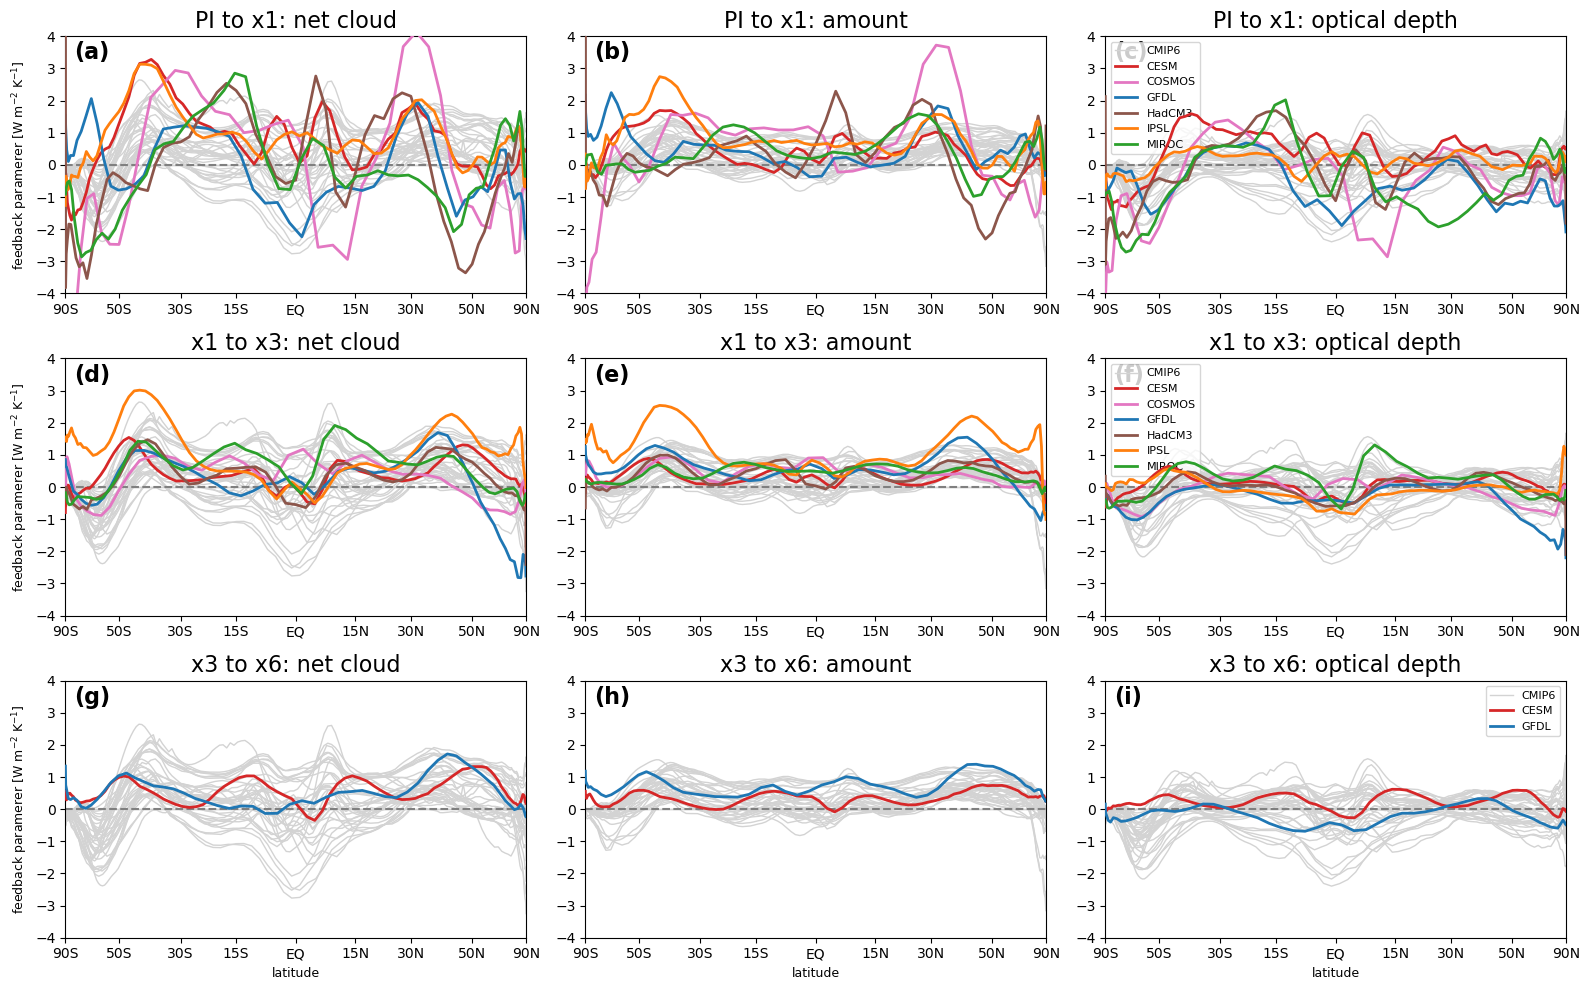

In [185]:
# zonal mean view
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

titles = ['net cloud', 'amount', 'optical depth']

# cmip6 background models
num_model = 0
for model in os.listdir(cmip_dir + "piControl/"):

    if model == '.DS_Store' or model == 'IPSL-CM6A-LR' or model == 'CMCC-CM2-SR5' or model == 'FGOALS-g3':
        continue
    
    aprp_file = model + '.piControl.to.abrupt-4xCO2.aprp.nc'
    aprp      = xr.open_dataset(data_dir + '/cmip/' + aprp_file, decode_times=False)
    aprp = aprp.where(aprp <= 1e6, np.nan)
    aprp_ym   = aprp.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp.lat))
    
    gmst1     = aprp_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT        = (gmst2 - gmst1).values

    var_list = ['cld','cld_c','cld_ga']
    for var_idx, var in enumerate(var_list):
        if var == 'cld_ga':
            cld_ga = aprp_ym['cld_ga'].mean('lon') / dT
            cld_mu = aprp_ym['cld_mu'].mean('lon') / dT
            aprp_ym_zm = cld_ga + cld_mu
        else:
            aprp_ym_zm = aprp_ym[var].mean('lon') / dT
        if num_model == 0:
            axs[0,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1, label='CMIP6' )
            axs[1,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1, label='CMIP6' )
            axs[2,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1, label='CMIP6' )
        else:
            axs[0,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
            axs[1,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
            axs[2,var_idx].plot(np.sin(np.radians(aprp_ym.lat)), aprp_ym_zm, linewidth=1, color='lightgray', zorder=1 )
            
    num_model +=1
        

for model in deepmip_dict.keys():

    print(model)
    if model == 'NorESM1-F':
        continue
    elif model == 'IPSLCM5A2':
        file_1 = model + '.deepmip-eocene-p1-PI.to.deepmip-eocene-p1-x1.5.aprp.nc'
        file_2 = model + '.deepmip-eocene-p1-x1.5.to.deepmip-eocene-p1-x3.aprp.nc'
    else:
        file_1 = model + '.deepmip-eocene-p1-PI.to.deepmip-eocene-p1-x1.aprp.nc'
        file_2 = model + '.deepmip-eocene-p1-x1.to.deepmip-eocene-p1-x3.aprp.nc'

    aprp_1      = xr.open_dataset(data_dir + '/deepmip/' + file_1, decode_times=False)
    aprp_1 = aprp_1.where(aprp_1 <= 1e6, np.nan)
    aprp_1_ym   = aprp_1.mean('time')

    aprp_2      = xr.open_dataset(data_dir + '/deepmip/' + file_2, decode_times=False)
    aprp_2 = aprp_2.where(aprp_2 <= 1e6, np.nan)
    aprp_2_ym   = aprp_2.mean('time')

    # calculate area weights
    coslat     = np.cos(np.deg2rad(aprp_1_ym.lat))
    
    gmst1     = aprp_1_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_1_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT1        = (gmst2 - gmst1).values

    print(dT1)
    gmst1     = aprp_2_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
    gmst2     = aprp_2_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
    dT2       = (gmst2 - gmst1).values

    if model == 'CESM1.2-CAM5' or model == 'GFDL-CM2.1':
        file_3 = model + '.deepmip-eocene-p1-x3.to.deepmip-eocene-p1-x6.aprp.nc'
        aprp_3      = xr.open_dataset(data_dir + '/deepmip/' + file_3, decode_times=False)
        aprp_3      = aprp_3.where(aprp_3 <= 1e6, np.nan)
        aprp_3_ym   = aprp_3.mean('time')

        gmst1     = aprp_3_ym['tas1'].weighted(coslat).mean(('lat','lon')) - 273.15
        gmst2     = aprp_3_ym['tas2'].weighted(coslat).mean(('lat','lon')) - 273.15
        dT3       = (gmst2 - gmst1).values
        
    var_list = ['cld','cld_c','cld_ga']
    for var_idx, var in enumerate(var_list):

        if var == 'cld_ga':
            cld_ga = aprp_1_ym['cld_ga'].mean('lon') / dT1
            cld_mu = aprp_1_ym['cld_mu'].mean('lon') / dT1
            aprp_1_ym_zm = cld_ga + cld_mu
        else:
            aprp_1_ym_zm = aprp_1_ym[var].mean('lon') / dT1    
        # aprp_1_ym_zm = aprp_1_ym[var].mean('lon') / dT1
        axs[0,var_idx].set_title("PI to x1: " + titles[var_idx], fontsize=16)
        axs[0,var_idx].plot(np.sin(np.radians(aprp_1_ym.lat)), aprp_1_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )

        if var == 'cld_ga':
            cld_ga = aprp_2_ym['cld_ga'].mean('lon') / dT2
            cld_mu = aprp_2_ym['cld_mu'].mean('lon') / dT2
            aprp_2_ym_zm = cld_ga + cld_mu
        else:
            aprp_2_ym_zm = aprp_2_ym[var].mean('lon') / dT2 
        # aprp_2_ym_zm = aprp_2_ym[var].mean('lon') / dT2
        axs[1,var_idx].set_title("x1 to x3: " + titles[var_idx], fontsize=16)
        axs[1,var_idx].plot(np.sin(np.radians(aprp_2_ym.lat)), aprp_2_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )

        if model == 'CESM1.2-CAM5' or model == 'GFDL-CM2.1':

            if var == 'cld_ga':
                cld_ga = aprp_3_ym['cld_ga'].mean('lon') / dT3
                cld_mu = aprp_3_ym['cld_mu'].mean('lon') / dT3
                aprp_3_ym_zm = cld_ga + cld_mu
            else:
                aprp_3_ym_zm = aprp_3_ym[var].mean('lon') / dT3 
            # aprp_3_ym_zm = aprp_3_ym[var].mean('lon') / dT3
            axs[2,var_idx].set_title("x3 to x6: " + titles[var_idx], fontsize=16)
            axs[2,var_idx].plot(np.sin(np.radians(aprp_3_ym.lat)), aprp_3_ym_zm, linewidth=2, color=deepmip_dict[model]['pcolor'], label=deepmip_dict[model]['group'], zorder=999 )

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)']
plot_num = 0
for ax in axs.flat:
    ax.axhline(y=0.0, color='gray', linestyle='--',zorder=1)
    ax.set_ylim([-4, 4])
    ax.set_xlim([np.sin(np.radians(-90)), np.sin(np.radians(90))])
    # Setting custom x-axis ticks and labels
    tick_positions = np.sin(np.radians(np.array([-90, -50, -30, -15, 0, 15, 30, 50, 90])))
    tick_labels = ['90S', '50S', '30S', '15S', 'EQ', '15N', '30N', '50N', '90N']
    ax.set_xticks(tick_positions, tick_labels)
    ax.text(0.02, 0.98, panels[plot_num], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    plot_num += 1
    # ax.set_xticks([12.5,15,17.5,20,22.5,25,27.5,30,32.5], ["","15","","20","","25","","30",""])
    
# axs[0,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))
# axs[1,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))
# axs[2,0].legend( prop={"size": 10}, bbox_to_anchor=(-0.17, 0.8))

axs[0,2].legend( prop={"size": 8})
axs[1,2].legend( prop={"size": 8})
axs[2,2].legend( prop={"size": 8})

axs[2,0].set_xlabel('latitude', fontsize=9)
axs[2,1].set_xlabel('latitude', fontsize=9)
axs[2,2].set_xlabel('latitude', fontsize=9)

axs[0,0].set_ylabel('feedback paramerer [W m$^{-2}$ K$^{-1}$]', fontsize=9)
axs[1,0].set_ylabel('feedback paramerer [W m$^{-2}$ K$^{-1}$]', fontsize=9)
axs[2,0].set_ylabel('feedback paramerer [W m$^{-2}$ K$^{-1}$]', fontsize=9)

fig.tight_layout()

fig.savefig(figure_dir + '/zonal_mean_cloud_feedbacks.pdf', bbox_inches='tight')


- large spread in cloud response in DeepMIP ensemble
- x1 to x3 highlights again the overall positive DeepMIP cloud feedbacks
- strong warming in IPSL due to less clouds in high latitudes
- strong cooling in GFDL in NH high latitudes, mainly due to scattering (i.e. composition changes)
- x3-x6 GFDL model in Arctic now very similar to CESM and CMIP6 models